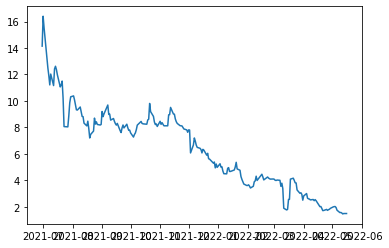

In [2]:
import matplotlib.pyplot as plt# plotting library
import yfinance as yf
sp500 = yf.Ticker("^GSPC").history(period='max')
msft = yf.Ticker("MSFT").history(period='max')
didi = yf.Ticker("DIDI").history(period='max')
didi_close = didi['Close']
plt.plot(didi_close)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline

import pmdarima as pm
print(f"Using pmdarima {pm.__version__}")
# Using pmdarima 1.5.2
from pmdarima.datasets.stocks import load_msft
df = load_msft()
df.head()


Using pmdarima 1.8.5


,Date,Open,High,Low,Close,Volume,OpenInt
0,1986-03-13,0.06720,0.07533,0.06720,0.07533,1371330506,0
1,1986-03-14,0.07533,0.07533,0.07533,0.07533,409569463,0
2,1986-03-17,0.07533,0.07533,0.07533,0.07533,176995245,0
3,1986-03-18,0.07533,0.07533,0.07533,0.07533,90067008,0
4,1986-03-19,0.07533,0.07533,0.07533,0.07533,63655515,0


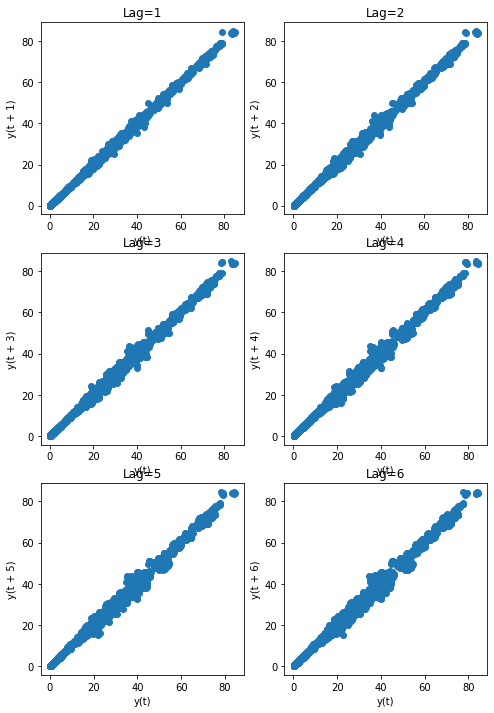

In [8]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(8, 12))
plt.title('MSFT Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(df['Open'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

plt.show()


In [20]:
from pmdarima.model_selection import train_test_split

train_len = int(df.shape[0] * 0.8)
train_data, test_data = train_test_split(df, train_size=train_len)

y_train = train_data['Open'].values
y_test = test_data['Open'].values

print(f"{train_len} train samples")
print(f"{df.shape[0] - train_len} test samples")
# 6386 train samples
# 1597 test samples


6386 train samples
1597 test samples


In [21]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
# Estimated differencing term: 1


Estimated differencing term: 1


In [22]:
auto = pm.auto_arima(
    y_train, d=n_diffs, seasonal=False, stepwise=True,
    suppress_warnings=True, max_p=6, trace=2)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5642.904, Time=1.69 sec
First viable model found (5642.904)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5640.878, Time=0.37 sec
New best model found (5640.878 < 5642.904)
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5640.426, Time=0.65 sec
New best model found (5640.426 < 5640.878)
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5640.350, Time=0.35 sec
New best model found (5640.350 < 5640.426)
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5639.441, Time=0.15 sec
New best model found (5639.441 < 5640.350)
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5640.152, Time=1.75 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.960 seconds


In [16]:
fc, conf_int = auto.predict(n_periods=1, return_conf_int=True)


In [19]:
y_test

array([22.45 , 22.471, 22.471, ..., 84.14 , 84.11 , 83.79 ])

In [18]:
conf_int

array([[82.95443439, 84.62556561]])

In [23]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    # model.update(new_ob)
    model.update(fc)

print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")
# Mean squared error: 0.34238951346274243
# SMAPE: 0.9825490519101439


Mean squared error: 591.081984398873
SMAPE: 51.12436178151192


/tmp/ipykernel_4457/332610709.py:13: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes[0].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
/tmp/ipykernel_4457/332610709.py:32: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())


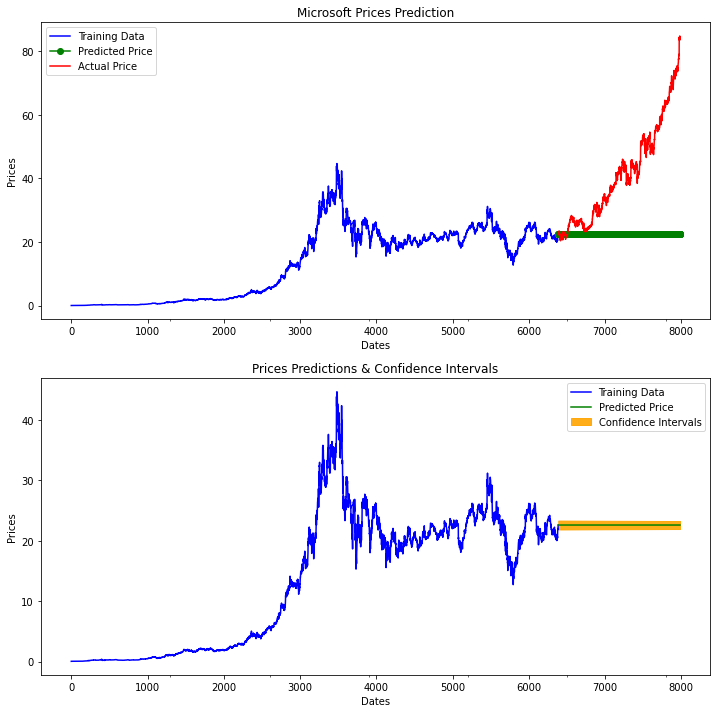

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, forecasts, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[0].set_title('Microsoft Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

axes[0].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[1].legend()

plt.show()
